# Training score-based diffusion model from first principles

In this part, we will walk step-by-step over the key steps of training a diffusion model.
The use-case here is to learn a diffusion model to generate a cloud of points that writes the word *"AI"*.


The dataset is available in the folder ``assets/2D_data/``


## Exploring the dataset

In [1]:
import torch
import matplotlib.pyplot as plt

# load data
cloud_points = torch.load("assets/2D_data/cloud_points.pt")

# get the number of samples
cloud_points.shape

/var/folders/20/q6ksctfs1zsdnw1xfyg1zblw0000gp/T/ipykernel_6993/160136920.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cloud_points = torch.load("assets/2D_data/cloud

torch.Size([20000, 2])

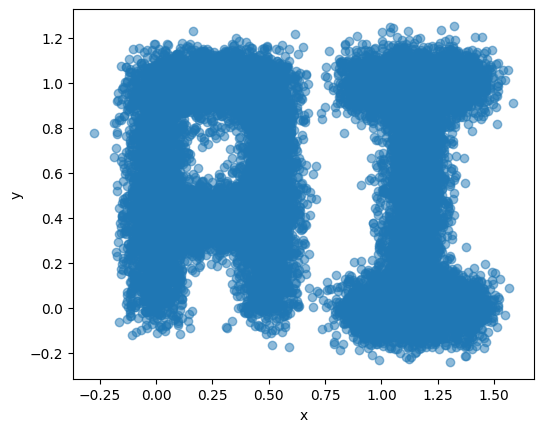

In [2]:
# plot cloud of points
fig, ax = plt.subplots()

ax.scatter(
    cloud_points[:, 0], cloud_points[:, 1], alpha=0.5
)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect(1)

**Note:**
For the analogy, in the case of a dataset of images, each point in the cloud of points will represent an image

## Forward process

Let's turn the dataset into a Gaussian distribution.
This can be described using a Markov process
$$
x_t  = \sqrt{\alpha}_t x_{t-1} + \sqrt{1 - \alpha_t} \varepsilon_t \\
x_0  \sim p_{data}, \quad
(\varepsilon_t)_t \overset{iid}{\sim} \mathcal{N}(0, I)
$$

We needn't to follow recurrently the chain $x_0 \rightarrow x_1 \rightarrow x_2 \rightarrow \dots \rightarrow x_t$ to get a sample $x_t$, we can jump directly from $x_0 \rightarrow x_t$

$$
x_t  = \sqrt{\bar{\alpha}}_t x_0 + \sqrt{1 - \bar{\alpha_t}} \epsilon_t, \quad
\bar{\alpha}_t = \textstyle \prod_k \alpha_k
$$

**Question**: Can you show it?


The sequence $\bar{\alpha}_t$ is the so called **noise scheduler**.

Let's import linear scheduler an see what it does.
It is available in the provided code in under ``py_code/diffusion.py``.

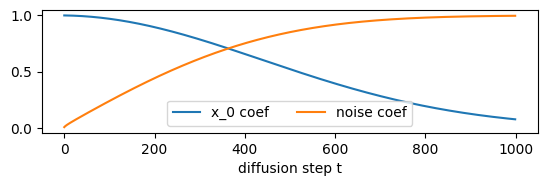

In [3]:
# let's plot the scheduler
from assets.py_code.diffusion import linear_schedule

n_diffusion_steps = 1000
alphas_cumprod = linear_schedule(n_diffusion_steps)


fig, ax = plt.subplots()

ax.plot(alphas_cumprod.sqrt(), label="x_0 coef")
ax.plot((1 - alphas_cumprod).sqrt(), label="noise coef")

ax.set_xlabel("diffusion step t")
ax.set_aspect(250)
ax.legend(loc="lower center", ncols=2)

**Question**: Can you comment this figure? what happens to the $x_0$ and the noise as the time evolve ?

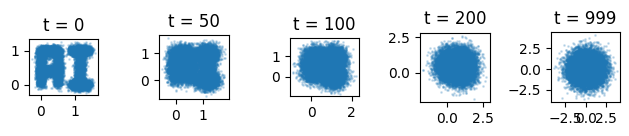

In [4]:

selected_time = [0, 50, 100, 200, 999]

fig, axes = plt.subplots(ncols=len(selected_time),)

for ax, t in zip(axes, selected_time):
    acp_t = alphas_cumprod[t]
    noise = torch.randn_like(cloud_points)

    x_t = acp_t.sqrt() * cloud_points + (1 - acp_t).sqrt() * noise

    ax.scatter(x_t[:, 0], x_t[:, 1], s=1, alpha=0.2)
    ax.set_title(f"{t = }")
    ax.set_aspect(1)

fig.tight_layout()

## Learning a Denoising Diffusion Probabilistic Model (DDPM) 


We want to learn a noise predictor
$$
\epsilon_{\theta}(x_t, t)
$$
given an $x_t$, it predict the noise that was added to $x_0$.

We model the noise predictor as a Neural Network.

Notice that we have to learn a NN that depends on time.
Therefore, we need a way to embed the information of time in it.
We achieve that using positional encoding.

Let's learn a simple MLP to predict the added noise.
For positional encoding, we will learn a table of vector, where each vector is an embedding of a time step. 

We will implement this architecture

<img src="./illustrations/architecutre.png" />

In [5]:
import torch
from torch import nn


class EpsilonNet(nn.Module):

    def __init__(self, d_encoding=20, n_blocks=5, n_diffusion_steps=50):
        super().__init__()

        self.d_encoding = d_encoding
        self.n_blocks = n_blocks
        self.n_diffusion_steps = n_diffusion_steps

        self.position_encoder = nn.Embedding(
            embedding_dim=self.d_encoding, num_embeddings=n_diffusion_steps
        )

        self.encoder = nn.Sequential(
            nn.Linear(2, self.d_encoding),
            nn.BatchNorm1d(self.d_encoding),
        )

        layers = [BlockMLP(d_encoding, d_encoding) for _ in range(n_blocks)]
        self.network = nn.Sequential(*layers)

        self.decoder = nn.Sequential(
            nn.Linear(self.d_encoding, 2),
            nn.BatchNorm1d(2)
        )

    def forward(
        self, noisy_points: torch.Tensor, t: int | torch.Tensor
    ) -> torch.Tensor:

        out = self.encoder(noisy_points) + self.position_encoder(t)
        out = self.network(out)
        out = self.decoder(out)

        return out


class BlockMLP(nn.Module):

    def __init__(self, in_features, out_features):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.ReLU(),
            nn.BatchNorm1d(out_features),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)


We can show that training a diffusion models reduces to minimizes the following loss

$$
\hat{\theta} = \arg\min_\theta \ \mathbb{E}_{x_0, t, \epsilon} \| \epsilon - \epsilon_{\theta}(x_t, t) \|^2
$$

Let's train the model for 1000 epoch using Adam optimizer with learning rate of ``lr=0.01``.

**Question**: from the code below, what are the other tweaks used for training the model?

In [6]:
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR

device = "cpu"

data_loader = DataLoader(cloud_points, batch_size=len(cloud_points) // 10, shuffle=True)

n_diffusion_steps = 1000
n_epochs = 1000
lr = 1e-2

alphas_cumprod = linear_schedule(n_diffusion_steps)
alphas_cumprod = alphas_cumprod.to(device)

eps_net = EpsilonNet(d_encoding=20, n_blocks=5, n_diffusion_steps=n_diffusion_steps)
eps_net.to(device)
eps_net.train()

optimizer = Adam(eps_net.parameters(), lr)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs, eta_min=lr / 100)


for epoch in (tbar := tqdm(range(n_epochs))):

    for batch_points in data_loader:

        optimizer.zero_grad()

        batch_points = batch_points.to(device)
        timesteps = torch.randint(
            size=(len(batch_points),),
            low=0,
            high=n_diffusion_steps,
            device=device
        )
        noise = torch.randn_like(batch_points, device=device)

        # noise the data
        acp_t = alphas_cumprod[timesteps][:, None]
        x_t = acp_t.sqrt() * batch_points + (1 - acp_t).sqrt() * noise

        # predict the added noise
        predicted_noise = eps_net(x_t, timesteps)

        # backprop the error
        loss = torch.norm(predicted_noise - noise) ** 2
        loss.backward()

        optimizer.step()
        tbar.set_description(f"loss per batch = {loss.item():.8f}")

    lr_scheduler.step()


loss per batch = 761.16735840: 100%|██████████| 1000/1000 [01:00<00:00, 16.41it/s]


Now that, we trained the model let set it to inference mode

In [7]:
eps_net.eval()
eps_net.requires_grad_(False);

## Generating new samples

A straight forward way to generate new sample is to simulate backward in time the markov chain.

This is commonly referred to as *ancestral sampling* [1].


<img src="./illustrations/sampling_algo.png" />

.. [1] Ho, Jonathan, Ajay Jain, and Pieter Abbeel.
    "Denoising diffusion probabilistic models."
    Advances in neural information processing systems 33 (2020): 6840-6851.

In [9]:
# Implement a function to perform ancestral sampling

def ancestral_sampling(initial_noise: torch.Tensor):
    device = initial_noise.device
    x_t = initial_noise

    for t in reversed(range(1, n_diffusion_steps)):
        t = torch.tensor(t, device=device)
        t_prev = t - 1
        pred_noise = eps_net(x_t, t)

        acp_t, acp_t_prev = alphas_cumprod[t], alphas_cumprod[t_prev]
        alpha_t = acp_t / acp_t_prev

        sigma_t = torch.sqrt((1 - acp_t_prev) / (1 - acp_t) * (1 - alpha_t))
        coef_pred_noise = (1 - alpha_t) / (1 - acp_t).sqrt()

        noise = torch.randn_like(x_t, device=device)
        x_t = (x_t - coef_pred_noise * pred_noise) / alpha_t.sqrt() + sigma_t * noise

    return x_t

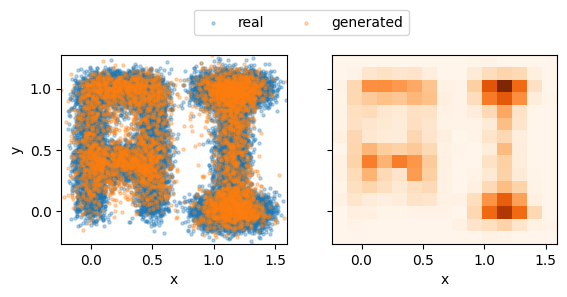

In [10]:
# generate new samples
n_samples = 5_000
initial_noise = torch.randn((n_samples, 2), device=device)
generated_points = ancestral_sampling(initial_noise)
generated_points = generated_points.cpu()

# plot generated vs. real
# make a second plot of the histogram of the generated points
fig, axes = plt.subplots(1, 2, sharey=True, sharex=True)
ax = axes[0]
for points, label in zip((cloud_points, generated_points), ("real", "generated")):
    p = points.cpu()
    ax.scatter(p[:, 0], p[:, 1], label=label, alpha=0.3, s=5)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect(1)

ax = axes[1]
ax.hist2d(generated_points[:, 0], generated_points[:, 1], bins=15, cmap="Oranges")
ax.set_xlabel("x")
ax.set_aspect(1)

fig.legend(loc="upper center", ncol=2,  bbox_to_anchor=(0.5, 0.8))
